#  Analyzing and Predicting Player Count Trends in Online Games

## Part 3: Model Construction

We will be utilizing a model known as SARIMA, or Seasonal Auto-Regressive Integrated Moving Average, as well as SARIMAX, the same model but accounting for exogeneous variables. 

### Modelling Goals

We wish to predict 3 separate things:

1. Number of players at a given time in the future
2. Player growth over a given period
3. Player growth at a given time.

### Modelling Process for SARIMA and SARIMAX

1. Transform Data
    - Outlier Removal
    - Discontinuity
2. Determine Seasonality
    - Spectral Analysis
3. Stationarity
    - ACF & PACF Analysis
4. Model Construction
5. Model Comparison

### Modelling Process for Our Data

We have to ask what exact model we want to construct. Would we want a model that is built on a single game and can only preedict that one game? Or should we build a model that takes an amalgamization of all games, and build a model based upon that? Or perhaps making a model based upon our control dataframe, Team Fortress 2, and seeing how this model performs on other games. 

1. Basic Modelling
    - CSGO
    - DOTA 2
    - Rocket League
    - Team Fortress 2
2. Amalgamized Modelling
    - Amalgamization Technique
    - Modelling
    - Testing
3. Control Model
    - Team Fortress 2 modelling
    - Testing

### 0. Data Retrieval and Inspection

In [33]:
# we import necessary libraries

!pip install -U fsds
!pip install statsmodels

import itertools
import statistics as stats
from fsds.imports import * 
from datetime import datetime
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

Requirement already up-to-date: fsds in c:\users\rmcar\anaconda\envs\learn-env\lib\site-packages (0.2.30)


In [34]:
# we import our dataframes

csgo = pd.read_csv('data/Clean/csgo.csv')
dota = pd.read_csv('data/Clean/dota.csv')
rl = pd.read_csv('data/Clean/rl.csv')
tf = pd.read_csv('data/Clean/tf.csv')

ls = [csgo, dota, rl, tf]

# our time column did not import as a datetime object, so we have to complete this again. 

for df in ls:
    
    for i in range(len(df['time'])):
        t = df['time'][i]
        
        df['time'][i] = str(t).replace('-', '')
        
    df['time'] = pd.to_datetime(df['time'], format = '%Y%m%d')

ls = list(map(lambda df: df.drop(columns = ['Unnamed: 0', 'index']), ls))


# Raw Attempt at Modelling Player Count for our Control DF, Team Fortress 2 - SARIMA

In [35]:
tf = ls[3]

In [36]:
# we update 'time' to be our index

tf.set_index(tf['time'], inplace = True)

In [37]:
tf = tf.drop(columns = ['time', 'viewers', 'event', '%chg_players', '%chg_viewers'])

In [38]:
# filling instances of players = 0 with preceding non-zero player count

for i in range(len(tf['players'])):
    if tf['players'][i] == 0:
        tf['players'][i] = tf['players'][i-1]

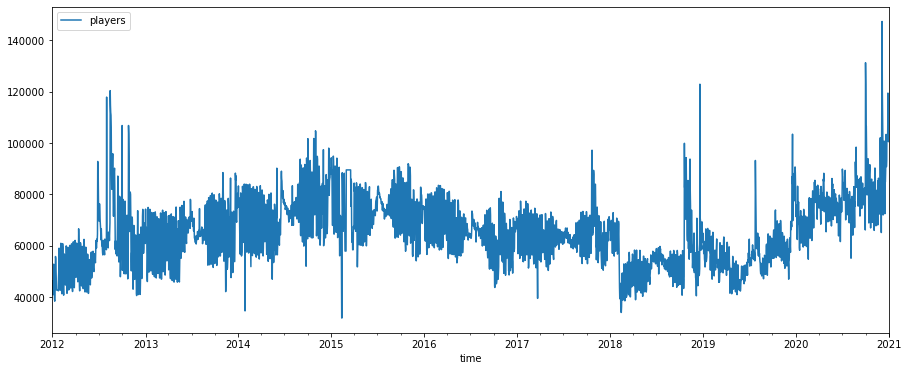

            players
time               
2012-01-01  46374.0
2012-01-02  45005.0
2012-01-03  40923.0
2012-01-04  43962.0
2012-01-05  46017.0


In [39]:
# we group our data weekly

#tf = tf.groupby(pd.Grouper(key = 'time', freq = 'W')).mean()


tf_plot = tf.copy()
tf_plot.plot(figsize = (15,6))
plt.show()
print(tf_plot.head())


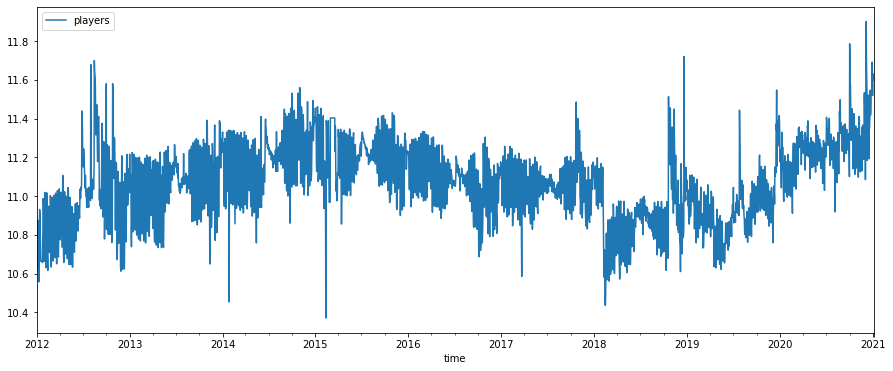

              players
time                 
2012-01-01  10.744494
2012-01-02  10.714529
2012-01-03  10.619448
2012-01-04  10.691081
2012-01-05  10.736766


In [40]:
# compare to logged data
tf_plot = tf.copy()

tf_plot['players'] = np.log(tf['players'])

tf_plot.plot(figsize = (15, 6))
plt.show()
print(tf_plot.head())

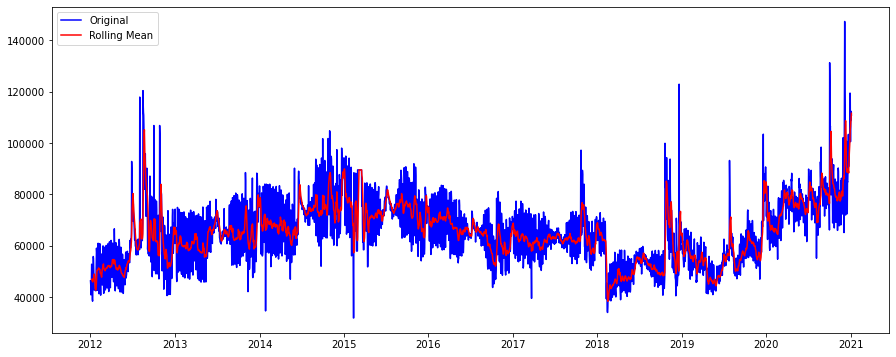

In [41]:
# comparing to rolling mean subtracted

roll_mean = tf.rolling(window = 7).mean()
fig = plt.figure(figsize = (15,6))
plt.plot(tf, color = 'blue', label = 'Original')
plt.plot(roll_mean, color = 'red', label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.show()

In [42]:
data_minus_roll_mean = tf - roll_mean
data_minus_roll_mean.dropna(inplace = True)
data_minus_roll_mean

,players
time,
2012-01-07,5808.571429
2012-01-08,1522.000000
2012-01-09,-7040.428571
2012-01-10,-7518.571429
2012-01-11,-2044.142857
...,...
2020-12-30,-5783.142857
2020-12-31,4489.285714
2021-01-01,148.571429


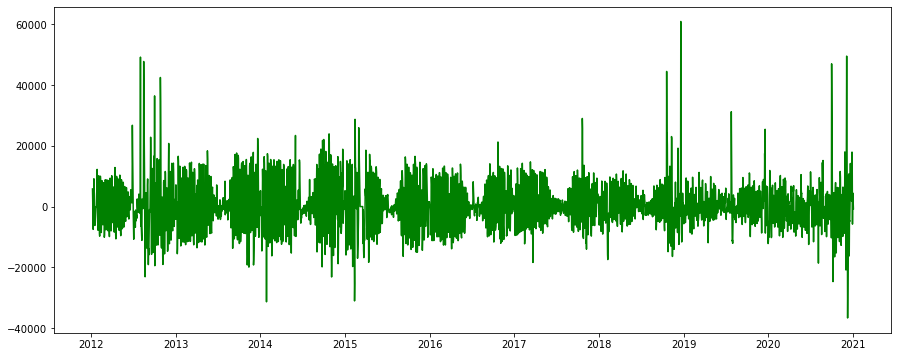

In [43]:
fig = plt.figure(figsize = (15,6))
plt.plot(data_minus_roll_mean, color = 'green')
plt.show()

In [44]:
# SARIMA model requires ARIMA(p, d, q) and Seasonal(P, D, Q)

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

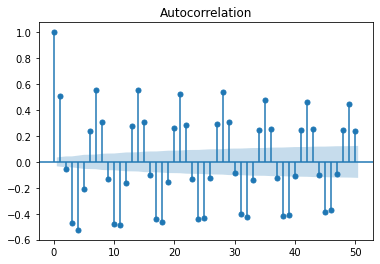

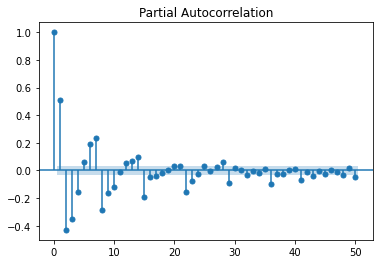

In [45]:
# we need to determine our seasonality time period, we are assuming right now that the seasonal trend is weekly. 

acf = plot_acf(data_minus_roll_mean, lags = 50)
pacf = plot_pacf(data_minus_roll_mean, lags = 50)
plt.show()

# our initial assumption of s = 7 is correct. 

In [46]:
ans = []
for combo in pdq:
    for combos in pdqs:
        mod = SARIMAX(data_minus_roll_mean,
                                           order = combo,
                                           seasonal_order = combos,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False,
                     freq = 'D')
        output = mod.fit()
        ans.append([combo, combos, output.aic])
        print('ARIMA {} x {}7 : AIC Calculated = {}'.format(combo, combos, output.aic))


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 0, 0, 7)7 : AIC Calculated = 68255.54236758835
ARIMA (0, 0, 0) x (0, 0, 1, 7)7 : AIC Calculated = 67449.3440560432
ARIMA (0, 0, 0) x (0, 1, 0, 7)7 : AIC Calculated = 67739.5144238252


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 1, 7)7 : AIC Calculated = 66050.25857186699
ARIMA (0, 0, 0) x (1, 0, 0, 7)7 : AIC Calculated = 66935.73178282959


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 1, 7)7 : AIC Calculated = 66140.72437823788
ARIMA (0, 0, 0) x (1, 1, 0, 7)7 : AIC Calculated = 66672.54056977382


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 1, 7)7 : AIC Calculated = 66023.83636306747
ARIMA (0, 0, 1) x (0, 0, 0, 7)7 : AIC Calculated = 67090.6554774956


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 0, 1, 7)7 : AIC Calculated = 66508.2785522629


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 0, 7)7 : AIC Calculated = 66867.88859895547


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (0, 1, 1, 7)7 : AIC Calculated = 65170.955498805866


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 0, 7)7 : AIC Calculated = 66261.46959323669


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 0, 1, 7)7 : AIC Calculated = 65817.34304352975


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 0, 7)7 : AIC Calculated = 65999.80993095366


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) x (1, 1, 1, 7)7 : AIC Calculated = 65509.3368871391
ARIMA (0, 1, 0) x (0, 0, 0, 7)7 : AIC Calculated = 68159.69100402045
ARIMA (0, 1, 0) x (0, 0, 1, 7)7 : AIC Calculated = 67321.30772765374

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.




ARIMA (0, 1, 0) x (0, 1, 0, 7)7 : AIC Calculated = 67519.73513894103


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 1, 7)7 : AIC Calculated = 66077.32607440217
ARIMA (0, 1, 0) x (1, 0, 0, 7)7 : AIC Calculated = 66752.61388074947


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 1, 7)7 : AIC Calculated = 66154.17075036108
ARIMA (0, 1, 0) x (1, 1, 0, 7)7 : AIC Calculated = 66630.5887671434


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 1, 7)7 : AIC Calculated = 66040.65503126655
ARIMA (0, 1, 1) x (0, 0, 0, 7)7 : AIC Calculated = 68112.58994898161


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 0, 1, 7)7 : AIC Calculated = 67328.2990692139
ARIMA (0, 1, 1) x (0, 1, 0, 7)7 : AIC Calculated = 67298.02989799109

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (0, 1, 1, 7)7 : AIC Calculated = 65890.4733756608


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 0, 7)7 : AIC Calculated = 66913.12606510235


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 0, 1, 7)7 : AIC Calculated = 66489.40934763927


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 0, 7)7 : AIC Calculated = 66515.14578766009


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) x (1, 1, 1, 7)7 : AIC Calculated = 66094.4367579484
ARIMA (1, 0, 0) x (0, 0, 0, 7)7 : AIC Calculated = 67261.70402201274


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 0, 1, 7)7 : AIC Calculated = 66475.17652372338
ARIMA (1, 0, 0) x (0, 1, 0, 7)7 : AIC Calculated = 66662.70955536352


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 1, 7)7 : AIC Calculated = 65377.870837521135
ARIMA (1, 0, 0) x (1, 0, 0, 7)7 : AIC Calculated = 66077.23950684599


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 1, 7)7 : AIC Calculated = 65672.12403639988


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)7 : AIC Calculated = 65795.2191548014


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 1, 7)7 : AIC Calculated = 65363.552674775136
ARIMA (1, 0, 1) x (0, 0, 0, 7)7 : AIC Calculated = 66963.67753428587


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 0, 1, 7)7 : AIC Calculated = 66333.657051935


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 0, 7)7 : AIC Calculated = 66643.20549446918


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (0, 1, 1, 7)7 : AIC Calculated = 65335.80190388707


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 0, 7)7 : AIC Calculated = 66038.4877359357


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 0, 1, 7)7 : AIC Calculated = 65621.92569235821


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 0, 7)7 : AIC Calculated = 65789.29308094617


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) x (1, 1, 1, 7)7 : AIC Calculated = 65321.815603235635
ARIMA (1, 1, 0) x (0, 0, 0, 7)7 : AIC Calculated = 68140.31767177895


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 0, 1, 7)7 : AIC Calculated = 67344.96162558245
ARIMA (1, 1, 0) x (0, 1, 0, 7)7 : AIC Calculated = 67369.81271977205


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 1, 7)7 : AIC Calculated = 66176.59213892673
ARIMA (1, 1, 0) x (1, 0, 0, 7)7 : AIC Calculated = 66906.23343281423

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 1, 7)7 : AIC Calculated = 66526.82485780054


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)7 : AIC Calculated = 66558.24994586717


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 1, 7)7 : AIC Calculated = 66159.31692307934


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 0, 7)7 : AIC Calculated = 67309.84221108069


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 0, 1, 7)7 : AIC Calculated = 66636.06257735567


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 0, 7)7 : AIC Calculated = 66691.98393973616


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (0, 1, 1, 7)7 : AIC Calculated = 65614.17240821646


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 0, 7)7 : AIC Calculated = 66334.15178194034


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 0, 1, 7)7 : AIC Calculated = 65989.6637586558


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 0, 7)7 : AIC Calculated = 65972.98900985483


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) x (1, 1, 1, 7)7 : AIC Calculated = 65606.558773162


In [47]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq        (0, 0, 1)
pdqs    (0, 1, 1, 7)
aic            65171
Name: 11, dtype: object

In [48]:
SARIMAX_MODEL = SARIMAX(data_minus_roll_mean, order = (0,0,1), seasonal_order = (0,1,1,7), enforce_stationarity = False,
                       enforce_invertibility = False)

output = SARIMAX_MODEL.fit()

print(output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4586      0.008     58.814      0.000       0.443       0.474
ma.S.L7       -0.8261      0.007   -120.078      0.000      -0.840      -0.813
sigma2      2.658e+07   1.99e+05    133.604      0.000    2.62e+07     2.7e+07


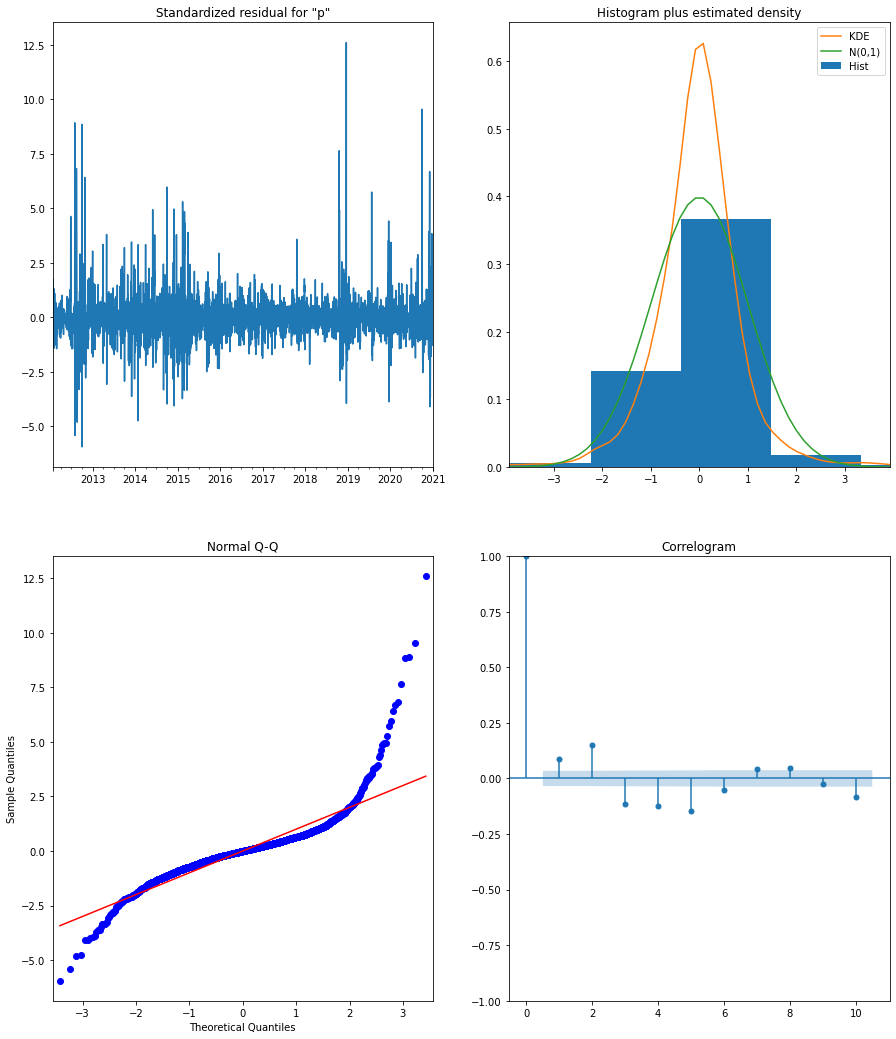

In [49]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [50]:
pred = output.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_conf = pred.conf_int()

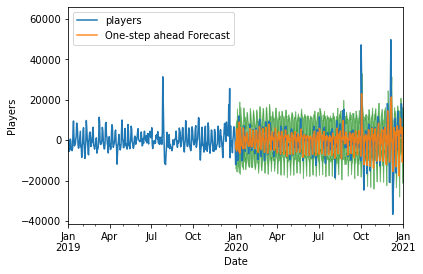

In [51]:
# Plot real vs predicted values along with confidence interval



# Plot observed values
ax = data_minus_roll_mean['2012':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Players')
ax.set(xlim = ("2019-01-01", "2021-01-01"))
plt.legend()

plt.show()

In [52]:
players_forecasted = pred.predicted_mean
players_truth = data_minus_roll_mean['2012-01-01':]['players']

# Compute the mean square error
mse = ((players_forecasted - players_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 33140668.53


# Modellable Data Construction

In [53]:
# we import necessary libraries

!pip install -U fsds
!pip install statsmodels

import itertools
import statistics as stats
from fsds.imports import * 
from datetime import datetime
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

Requirement already up-to-date: fsds in c:\users\rmcar\anaconda\envs\learn-env\lib\site-packages (0.2.30)


In [54]:
# we import our dataframes

csgo = pd.read_csv('data/Clean/csgo.csv')
dota = pd.read_csv('data/Clean/dota.csv')
rl = pd.read_csv('data/Clean/rl.csv')
tf = pd.read_csv('data/Clean/tf.csv')

ls = [csgo, dota, rl, tf]

# our time column did not import as a datetime object, so we have to complete this again. 

for df in ls:
    
    for i in range(len(df['time'])):
        t = df['time'][i]
        
        df['time'][i] = str(t).replace('-', '')
        
    df['time'] = pd.to_datetime(df['time'], format = '%Y%m%d')

ls = list(map(lambda df: df.drop(columns = ['Unnamed: 0', 'index']), ls))


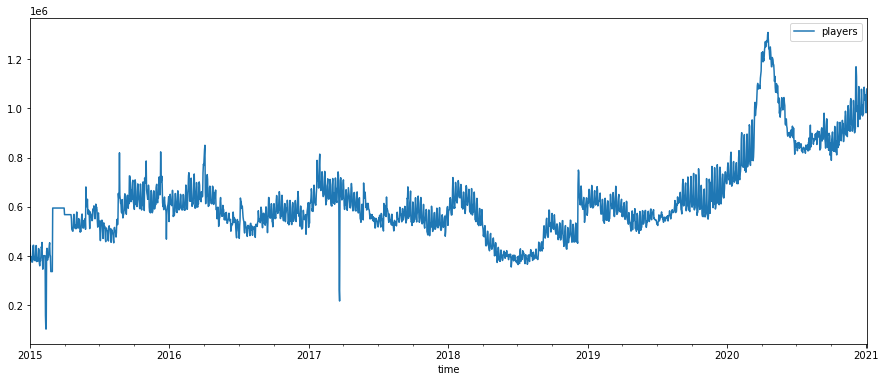

             players
time                
2015-01-01  443188.0
2015-01-02  383943.0
2015-01-03  398639.0
2015-01-04  389040.0
2015-01-05  376364.0


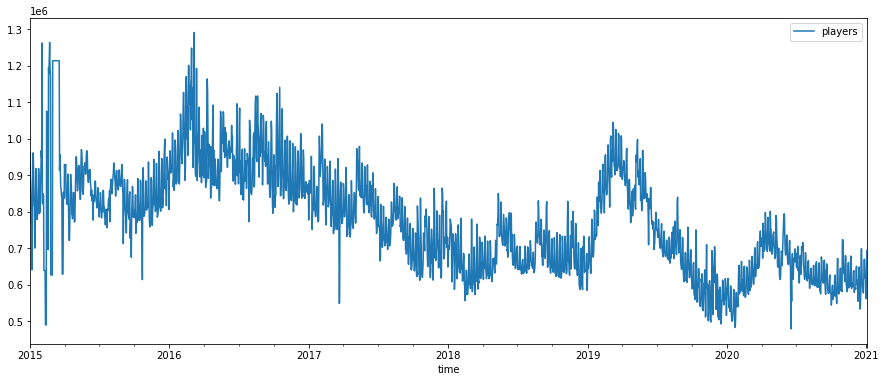

             players
time                
2015-01-01  961737.0
2015-01-02  878508.0
2015-01-03  835544.0
2015-01-04  770788.0
2015-01-05  844391.0


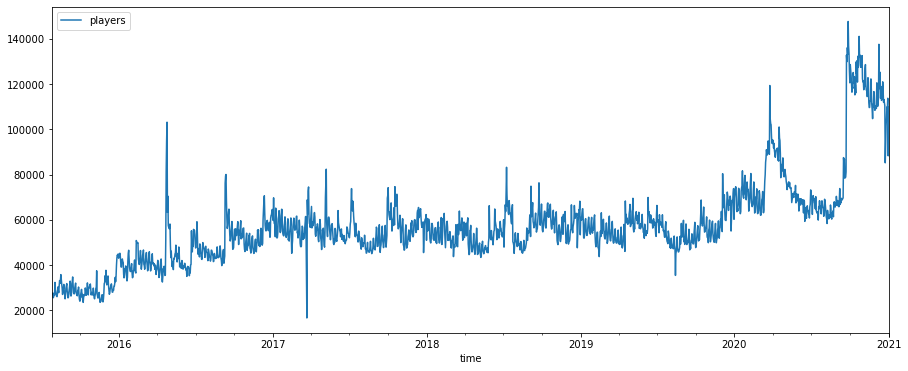

            players
time               
2015-07-27  27121.0
2015-07-28  27692.0
2015-07-29  25574.0
2015-07-30  26082.0
2015-07-31  27188.0


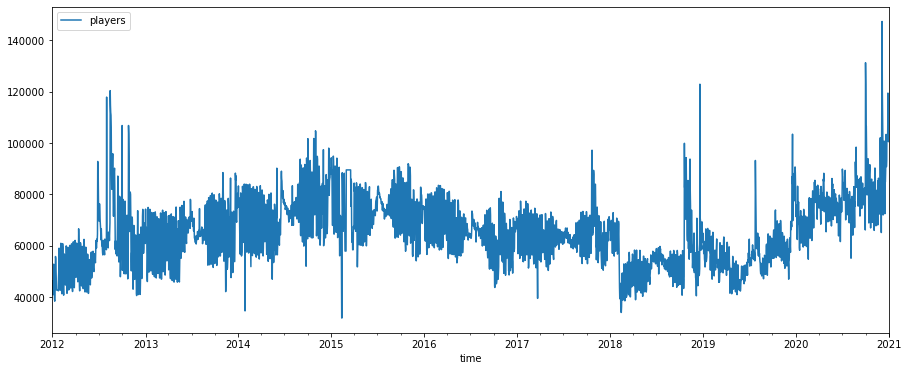

            players
time               
2012-01-01  46374.0
2012-01-02  45005.0
2012-01-03  40923.0
2012-01-04  43962.0
2012-01-05  46017.0


In [55]:
new_ls = []
for i, df in enumerate(ls):
    df.set_index(df['time'], inplace = True)
    df = df.drop(columns = ['viewers', 'event', '%chg_players', '%chg_viewers'])
    df = df.drop(columns = ['time'])
    for i in range(len(df)):
        if df['players'][i] == 0:
            df['players'][i] = df['players'][i-1]
    df_plot = df.copy()
    df_plot.plot(figsize = (15,6))
    plt.show()
    new_ls.append(df)
    print(df_plot.head())

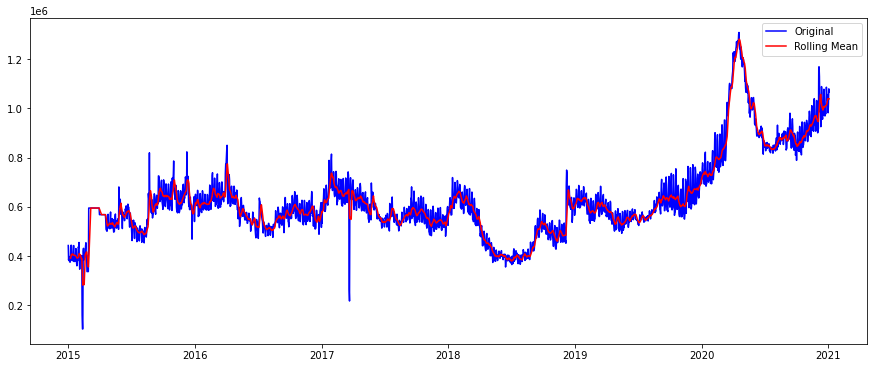

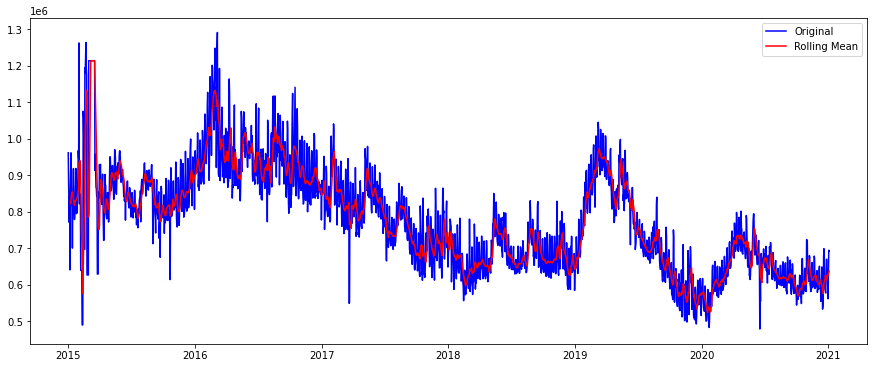

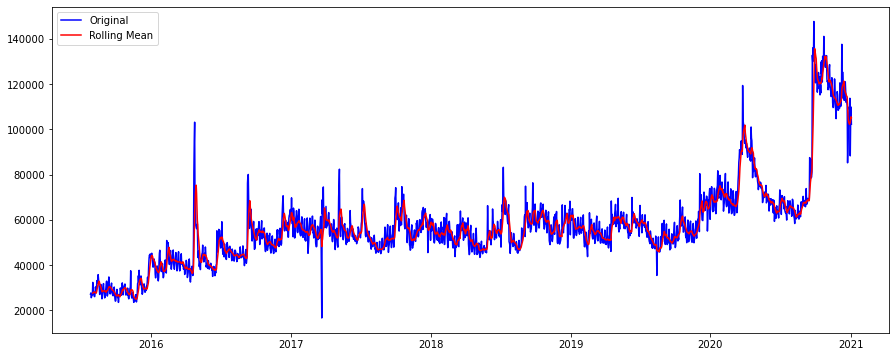

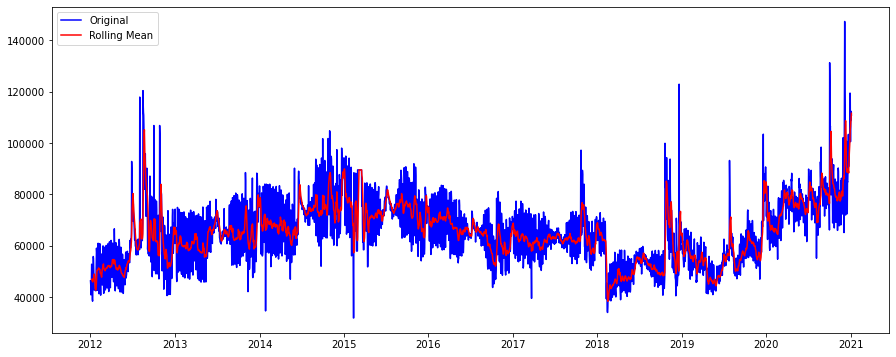

In [56]:
ls = new_ls

for df in ls:
    roll_mean = df.rolling(window = 7).mean()
    fig = plt.figure(figsize = (15,6))
    plt.plot(df, color = 'blue', label = 'Original')
    plt.plot(roll_mean, color = 'red', label = 'Rolling Mean')
    plt.legend(loc = 'best')
    plt.show()

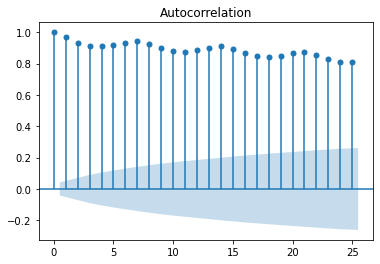

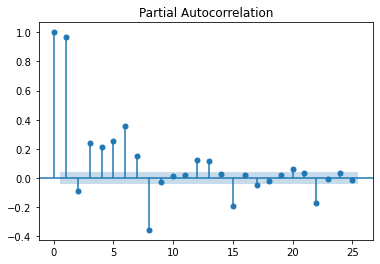

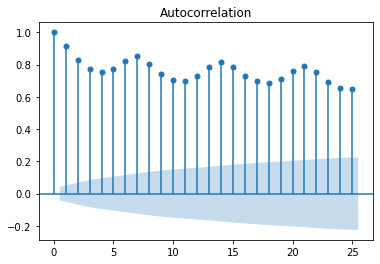

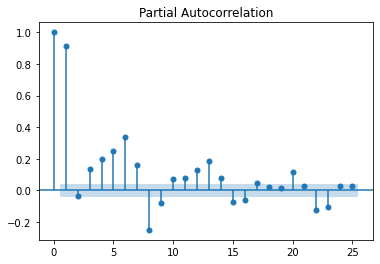

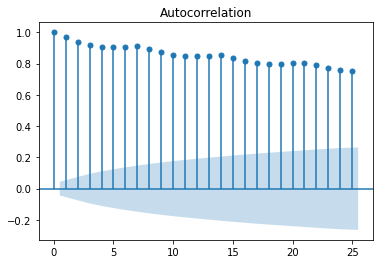

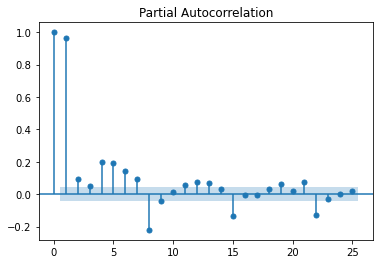

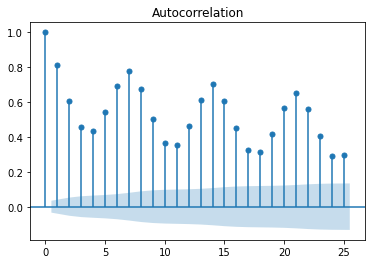

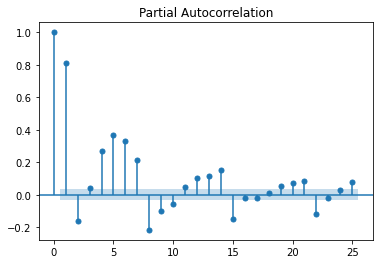

In [57]:
for df in ls:
    acf = plot_acf(df, lags = 25)
    pacf = plot_pacf(df, lags = 25)


In [59]:
p = q = d = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
ls[0]

,players
time,
2015-01-01,443188.0
2015-01-02,383943.0
2015-01-03,398639.0
2015-01-04,389040.0
2015-01-05,376364.0
...,...
2020-12-30,1056057.0
2020-12-31,982583.0
2021-01-01,1020715.0


In [27]:
ans_ls = []
for df in ls:
    
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = SARIMAX(df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df = ans_df.loc[ans_df['aic'].idxmin()].dropna()
    
    ans_ls.append(ans_df)

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

In [28]:
ans_ls[0]

pdq        (1, 0, 1)
pdqs    (0, 1, 1, 7)
aic          51184.9
Name: 43, dtype: object

In [29]:
ans_ls[1]

pdq        (1, 0, 1)
pdqs    (1, 1, 1, 7)
aic          53326.5
Name: 47, dtype: object

In [30]:
ans_ls[2]

pdq        (1, 0, 1)
pdqs    (0, 1, 1, 7)
aic            38539
Name: 43, dtype: object

In [31]:
ans_ls[3]

pdq        (1, 0, 1)
pdqs    (0, 1, 1, 7)
aic          66234.9
Name: 43, dtype: object

Modelling on raw data obviously does not work well. Instead, let's attempt to model on our % change of players column. 

In [32]:
new_ls = []
for i, df in enumerate(ls):
    df.set_index(df['time'], inplace = True)
    df = df.drop(columns = ['viewers', 'event', 'players', '%chg_viewers'])
    df = df.drop(columns = ['time'])
    #for i in range(len(df)):
     #   if df['players'][i] == 0:
      #      df['players'][i] = df['players'][i-1]
    df_plot = df.copy()
    df_plot.plot(figsize = (15,6))
    plt.show()
    new_ls.append(df)
    print(df_plot.head())

KeyError: 'time'

In [ ]:
ls = new_ls

for df in ls:
    roll_mean = df.rolling(window = 7).mean()
    fig = plt.figure(figsize = (15,6))
    plt.plot(df, color = 'blue', label = 'Original')
    plt.plot(roll_mean, color = 'red', label = 'Rolling Mean')
    plt.legend(loc = 'best')
    plt.show()

In [ ]:
for df in ls:
    acf = plot_acf(df, lags = 25)
    pacf = plot_pacf(df, lags = 25)


In [ ]:
p = q = d = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [ ]:
ans_ls = []
for df in ls:
    
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = SARIMAX(df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df = ans_df.loc[ans_df['aic'].idxmin()].dropna()
    
    ans_ls.append(ans_df)

In [ ]:
ans_ls[0]

In [ ]:
ans_ls[1]

In [ ]:
ans_ls[2]

In [ ]:
ans_ls[3]

In [ ]:
# mse

forecasted = pred.predicted_mean
